In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from numpy import array
import pickle
import string
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import clone_model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu

Using TensorFlow backend.


# 1) Load Documents 

In [0]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

filename = "/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [0]:
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [0]:
print(list(descriptions.keys())[:5])
print("Decsription of image 1000268201_693b08cb0e.jpg: ", descriptions['1000268201_693b08cb0e'])

['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615']
Decsription of image 1000268201_693b08cb0e.jpg:  ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [0]:
# Below path contains all the images
images = '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/'
print(images)
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/


In [0]:
# Below file contains the names of images to be used in train data
train_images_file = '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
# Create a list of all the training images with their full path names
train_img = []
for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images
print(train_img)

['/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/454691853_cc1e0fa6a1.jpg', '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/455611732_d65bf3e976.jpg', '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/456512643_0aac2fa9ce.jpg', '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/457631171_12b1aee828.jpg', '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/456299217_b2802efbc2.jpg', '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/455856615_f6361d9253.jpg', '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/454686980_7517fe0c2e.jpg', '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/457875937_982588d918.jpg', '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/458213442_12c59e61a0.jpg', '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/458183774_afe65abf67.jpg', '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/459284240_5a41

In [0]:
# Below file contains the names of images to be used in test data
test_images_file = '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
val_images_file = '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/flickr8ktextfiles/flickr_8k_val_dataset.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = list(set(open(test_images_file, 'r').read().strip().split('\n')))
val_images = list(set(open(val_images_file, 'r').read().strip().split('\n')))
# Create a list of all the test images with their full path names
test_images = list(set(test_images+val_images))
test_img = []
for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images
print(len(test_img))

1000


# 2) Clean Descriptions

In [0]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [0]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [0]:
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


# 3) Build Vocabulary

In [0]:
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


# 4) Inception V3 Model (42 layers)
---

Total params: 21,802,784<br/>
Trainable params: 21,768,352<br/>
Non-trainable params: 34,432

In [0]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')














96116736/96112376 [==============================] - 1s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

# 5) Preprocessing

In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

# 6) Encoding of Image to Vector

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

# 7) Encoding of Text to Vector
```
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

# Save the bottleneck train features to disk
with open("/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
print(test_img)
for img in test_img:
    #print(encoding_test[img[len(images)+1:]])
    encoding_test[img[len(images)+1:]] = encode(img)
    print(img)
print("Time taken in seconds =", time()-start)

# Save the bottleneck test features to disk
with open("/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)
```

In [0]:
train_features = load(open("/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


Photos: train=1000
[0.39160383 0.09566504 0.3783627  ... 0.6856693  0.88575846 0.17272465]


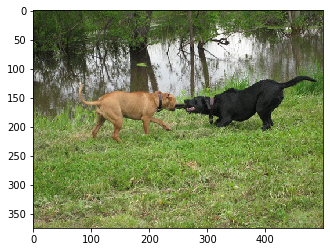

In [0]:
encoding_test = load(open("/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Pickle/encoded_test_images.pkl", "rb"))
print('Photos: train=%d' % len(encoding_test))
x = plt.imread('/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/3578914491_36019ba703.jpg')
plt.imshow(x)
print(encoding_test['3578914491_36019ba703.jpg'])

In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

In [0]:
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [0]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [0]:
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# Load Glove vectors
glove_dir = '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# 8) Data Preparation using Generator Function


```
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0
```

# 9) Word Embeddings

In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1652, 200)

# 10) Final Model Architecture

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
# Creating clone of the model
model_copy= keras.models.clone_model(model)

In [0]:
# Loading 2 models
model.load_weights('/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/models/model_final9.h5')
model_copy.load_weights('/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/model_final/model_10epochs_4_pics_per_batch.h5')

# 11) Testing

*   GREEDY Search
*   BLEU Score: Bilingual Evaluation Understudy

In [0]:
images = '/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images'

In [0]:
print(encoding_test.keys())

dict_keys(['461505235_590102a5bf.jpg', '460935487_75b2da7854.jpg', '463978865_c87c6ca84c.jpg', '464251704_b0f0c4c87a.jpg', '466956209_2ffcea3941.jpg', '468102269_135938e209.jpg', '468310111_d9396abcbd.jpg', '468608014_09fd20eb9b.jpg', '470373679_98dceb19e7.jpg', '473220329_819a913bbb.jpg', '476233374_e1396998ef.jpg', '476759700_8911f087f8.jpg', '480505313_2dc686e5db.jpg', '485245061_5a5de43e20.jpg', '486712504_36be449055.jpg', '486917990_72bd4069af.jpg', '488408004_a1e26d4886.jpg', '488590040_35a3e96c89.jpg', '488356951_b3b77ad832.jpg', '491405109_798222cfd0.jpg', '494792770_2c5f767ac0.jpg', '493109089_468e105233.jpg', '493621130_152bdd4e91.jpg', '494921598_af73bda568.jpg', '496110746_a93ca191ae.jpg', '497791037_93499238d8.jpg', '498444334_a680d318a1.jpg', '500446858_125702b296.jpg', '505929313_7668f021ab.jpg', '506367606_7cca2bba9b.jpg', '506738508_327efdf9c3.jpg', '509123893_07b8ea82a9.jpg', '510531976_90bbee22a2.jpg', '509778093_21236bb64d.jpg', '512101751_05a6d93e19.jpg', '51499019

In [0]:
def greedySearch(photo,model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [0]:
# list of references
references = dict()
for key,values in descriptions.items():
  references[key] = [word.split() for word in descriptions[key]]

In [0]:
# Calculate bleu score
def calc_bleu(references, candidate):
  return sentence_bleu(references, candidate)

In [0]:
score_bleu = 0
max_pics = dict()
print(len(encoding_test.keys()))
for key,value in encoding_test.items():
  image_key = key[:-4]
  image = encoding_test[key].reshape((1,2048))
  candidate_first = greedySearch(image,model)
  candidate_second = greedySearch(image,model_copy)
  score_first = calc_bleu(references[image_key], candidate_first.split())
  score_second = calc_bleu(references[image_key], candidate_second.split())
  if score_first>0.8 or score_second>0.8:
    max_pics[image_key] = score_first if score_first>score_second else score_second
  if(score_first>score_second):
    score_bleu += score_first
  else:
    score_bleu += score_second
  print(score_first,"    ",score_second)

In [0]:
score_bleu/1000

0.6346548061975009

# 12) Sample Test

['dog is playing in the deep snow', 'dog running through deep snow pack', 'dog runs through the deep snow', 'white dog is running through the snow', 'white dog running through snow']


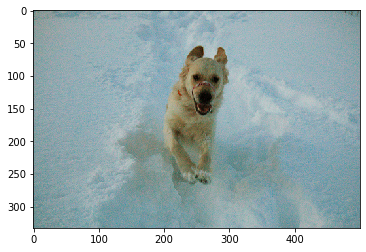

Greedy: dog is running through the snow
1.0
Greedy: white dog is running through the snow
1.0


In [0]:
image_sample = '317488612_70ac35493b'
x=plt.imread("/content/drive/My Drive/Flickr8k/Flickr_Data/Flickr_Data/Images/"+image_sample+".jpg")
image = encoding_test[image_sample+'.jpg'].reshape((1,2048))
print(descriptions[image_sample])
plt.imshow(x)
plt.show()
pred1 = greedySearch(image,model)
pred2 = greedySearch(image,model_copy)
print("Greedy:", pred1)
print(calc_bleu(references[image_sample], pred1.split()))
print("Greedy:", pred2)
print(calc_bleu(references[image_sample], pred2.split()))

TEST
```
OKAYISH: 3696698390_989f1488e7
Greedy: man in blue shirt and helmet is riding bike on the street
Greedy: man in blue shirt and jeans is riding bike on the road

GOOD: 3578914491_36019ba703
Greedy: two dogs play in the grass
Greedy: two brown dogs are playing together on the grass

OKAYISH: 3474406285_01f3d24b71
Greedy: dog is running through the grass
Greedy: dog is jumping over hurdle

GOOD: 2723477522_d89f5ac62b
Greedy: two dogs play in the grass
Greedy: two dogs are running through the grass

OKAYISH: 3071676551_a65741e372
Greedy: man in black wetsuit is surfing
Greedy: man in rough wetsuit is paddling through rough waters

BEST: 317488612_70ac35493b
Greedy: dog is running through the snow
Greedy: white dog is running through the snow
```

TRAIN



```
BEST: 2766765386_4c0beb939d
Greedy: man in wetsuit is waterskiing in the water
Greedy: man in black wetsuit is surfing in the ocean

OKAYISH: 2623982903_58ec7c5026
Greedy: greyhounds are racing on the track
Greedy: two dogs are racing on the track

OKAYISH: 3484070900_3e76d7fd30
Greedy: skier is jumping over snowy hill
Greedy: man in summer clothing is snowboarding down snowy hill

BEST: 2760371526_63f3d01760
Greedy: boy in swimming trunks is jumping into pool
Greedy: boy in swimming trunks is jumping into swimming pool

OKAYISH: 217583047_5e93e1e119
Greedy: man in blue and white life vest is sitting on boat
Greedy: man in black shirt is paddling kayak on river lined by river

GOOD: 1009434119_febe49276a (ONLY ONE CAPTION IS RIGHT)
Greedy: two dogs are running through the grass
Greedy: black and white dog is running through the grass


```